In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.mixture import GaussianMixture
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [165]:
# load dataset
df = pd.read_csv("Mental Health dataset1.csv")
print("Shape:", df.shape)
df.head()

Shape: (261328, 17)


,Gender,Country,Occupation,SelfEmployed,FamilyHistory,Treatment,DaysIndoors,HabitsChange,MentalHealthHistory,IncreasingStress,MoodSwings,SocialWeakness,CopingStruggles,WorkInterest,SocialWeakness.1,MentalHealthInterview,CareOptions
0,Female,UK,Others,No,Yes,No,15-30 days,No,Yes,Yes,High,No,Yes,Maybe,No,No,No
1,Female,USA,Housewife,No,Yes,No,15-30 days,Maybe,Maybe,Yes,High,Maybe,Yes,Maybe,Maybe,No,Not sure
2,Female,Canada,Others,No,No,Yes,More than 2 months,Maybe,No,No,Medium,No,No,No,No,No,Not sure
3,Female,Canada,Corporate,No,Yes,Yes,Go out Every day,No,Maybe,No,Medium,No,No,Maybe,No,No,Not sure
4,Female,UK,Corporate,No,No,Yes,More than 2 months,Yes,No,Maybe,Medium,Maybe,No,Maybe,Maybe,No,Not sure


In [153]:
# clean dataset
if "SocialWeakness.1" in df.columns:
    df = df.drop(columns=["SocialWeakness.1"])

df = df.dropna(subset=["SelfEmployed"])


df["Gender"] = df["Gender"].astype(str).str.lower().str.strip()
df["Gender"] = df["Gender"].replace({
    "male": "male", "m": "male", "man": "male",
    "female": "female", "f": "female", "woman": "female"
})
df["Gender"] = df["Gender"].where(df["Gender"].isin(["male", "female"]), "other")

In [154]:
lca_features = ["Occupation", "Gender", "Country",
                "SelfEmployed", "FamilyHistory", "DaysIndoors"]


ct = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), lca_features)
    ]
    
)

In [155]:
n_classes = 3  

lca_model = Pipeline(steps=[
    ("encoder", ct),
    ("gmm", GaussianMixture(n_components=n_classes, random_state=42))
])

lca_model.fit(df)


encoded = lca_model["encoder"].transform(df)
df["LatentClass"] = lca_model["gmm"].predict(encoded)

print("Latent Class Counts:")
print(df["LatentClass"].value_counts())
  

Latent Class Counts:
LatentClass
1    147314
0     79688
2     29970
Name: count, dtype: int64


In [156]:
outcomes = ["HabitsChange","MentalHealthHistory","IncreasingStress",
            "SocialWeakness","MoodSwings"]

def to_binary(col):
    col = col.astype(str).str.lower()
    return col.apply(lambda x: 
                     1 if x.startswith(("yes","y","often","high","frequent")) 
                     else 0)

for o in outcomes:
    df[o + "_bin"] = to_binary(df[o])

In [157]:
print("\n========== RQ2: OCCUPATION MENTAL HEALTH RISK WITHIN LATENT CLASSES ==========\n")

for c in sorted(df["LatentClass"].unique()):
    print(f"\n------ LATENT CLASS {c} ------")
    class_data = df[df["LatentClass"] == c]

    for o in outcomes:
        print(f"\nOutcome: {o}")
        risk = class_data.groupby("Occupation")[o + "_bin"].mean().sort_values(ascending=False)
        print(risk.head(10))


========== RQ2: OCCUPATION MENTAL HEALTH RISK WITHIN LATENT CLASSES ==========


------ LATENT CLASS 0 ------

Outcome: HabitsChange
Occupation
Others       0.420747
Student      0.401754
Housewife    0.379410
Business     0.374321
Corporate    0.309844
Name: HabitsChange_bin, dtype: float64

Outcome: MentalHealthHistory
Occupation
Others       0.376399
Business     0.327748
Housewife    0.303104
Corporate    0.297496
Student      0.287502
Name: MentalHealthHistory_bin, dtype: float64

Outcome: IncreasingStress
Occupation
Business     0.391606
Corporate    0.379968
Student      0.356188
Housewife    0.270162
Others       0.260632
Name: IncreasingStress_bin, dtype: float64

Outcome: SocialWeakness
Occupation
Housewife    0.357647
Business     0.344505
Corporate    0.298530
Student      0.273396
Others       0.246503
Name: SocialWeakness_bin, dtype: float64

Outcome: MoodSwings
Occupation
Student      0.470870
Others       0.303931
Business     0.266455
Housewife    0.260447
Corporate  

In [158]:
outcomes = ["HabitsChange",
            "MentalHealthHistory",
            "IncreasingStress",
            "SocialWeakness",
            "MoodSwings"]

def to_binary(col):
    col = col.astype(str).str.lower()
    return col.apply(
        lambda x: 1 if x.startswith(("yes", "y", "often", "high", "frequent"))
        else 0
    )

for o in outcomes:
    df[o + "_bin"] = to_binary(df[o])

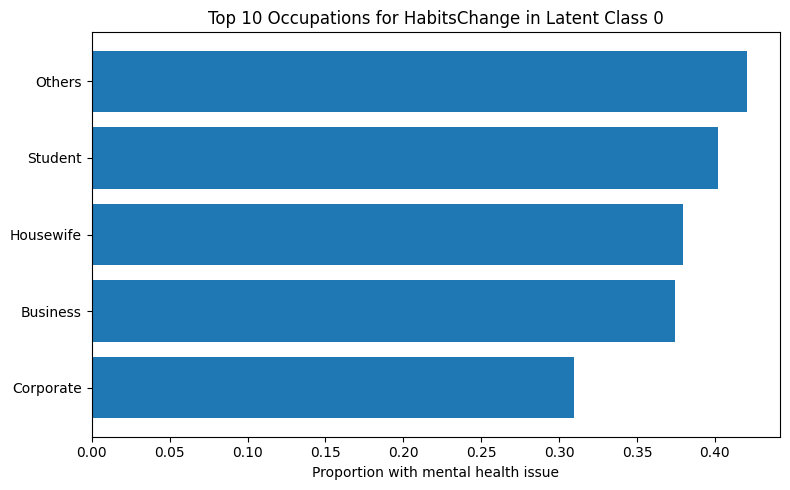

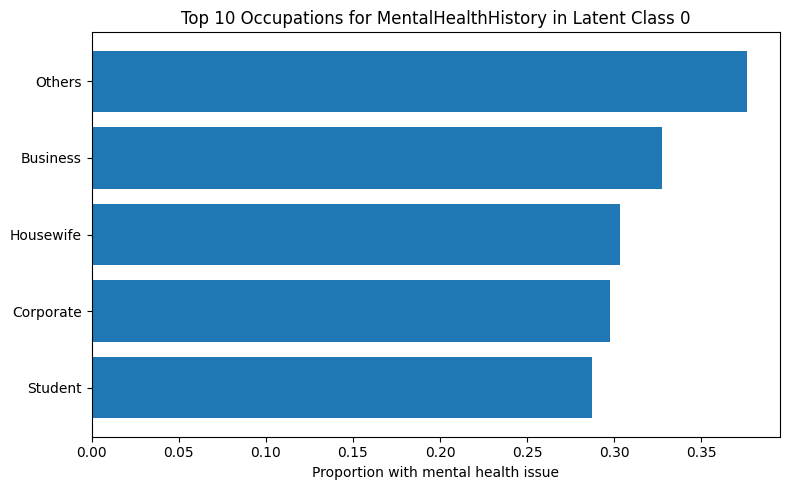

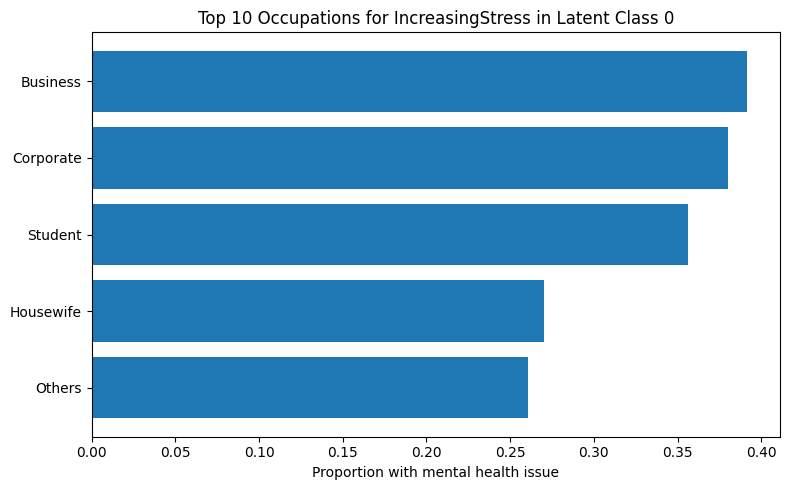

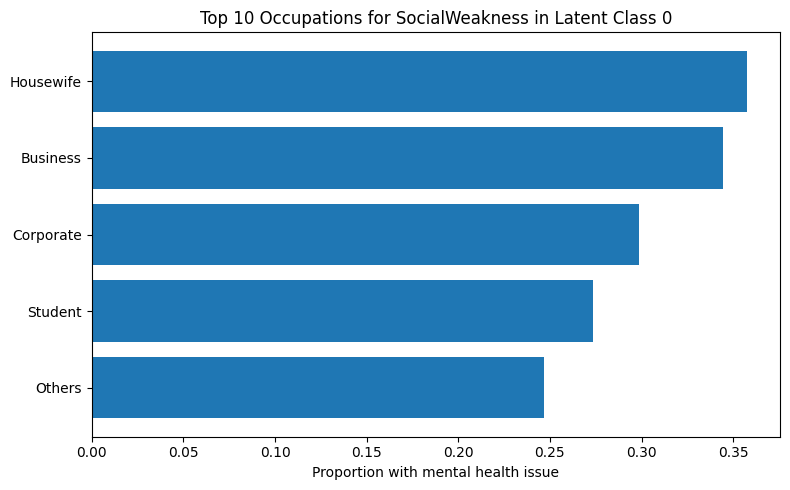

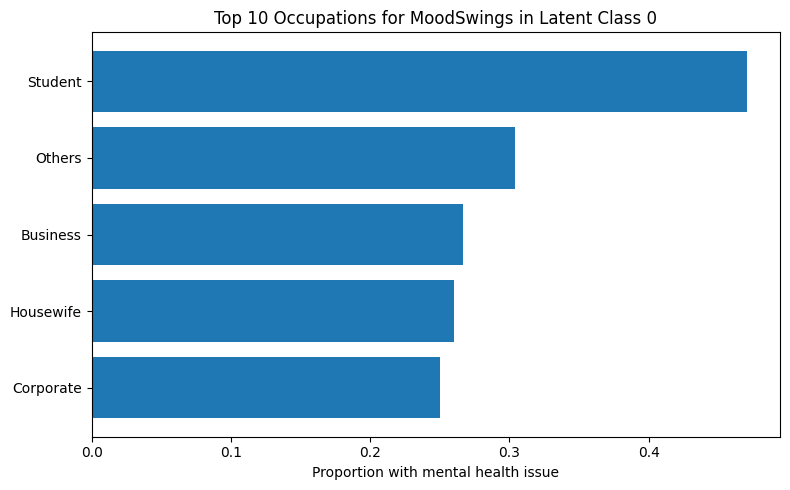

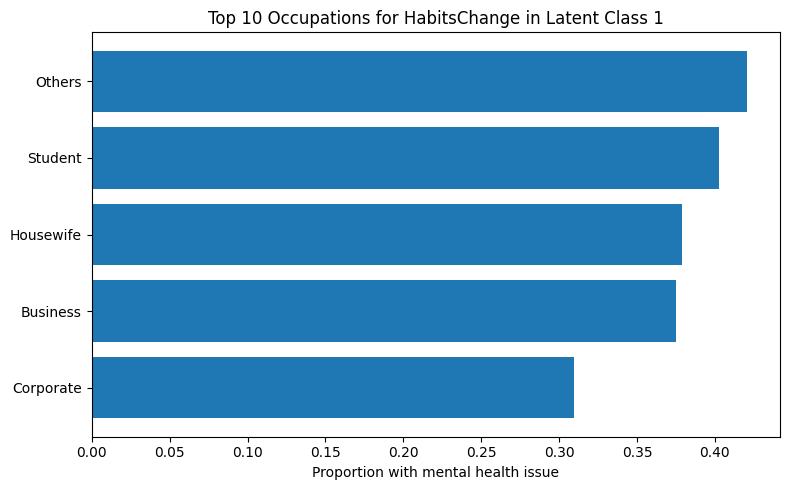

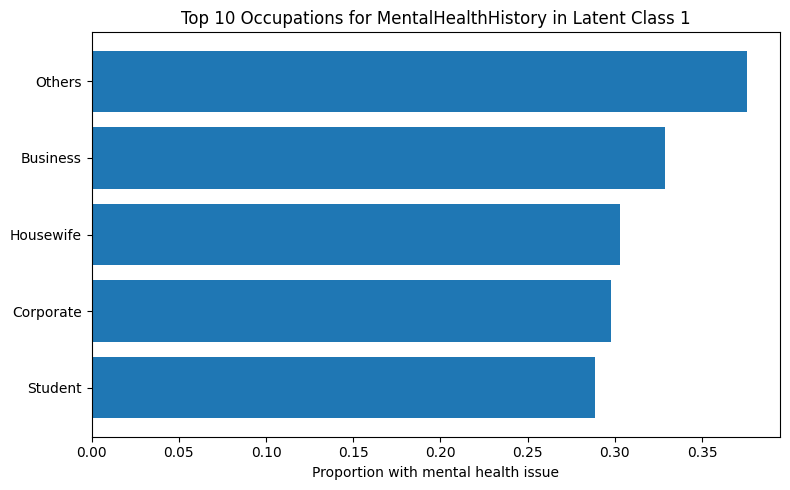

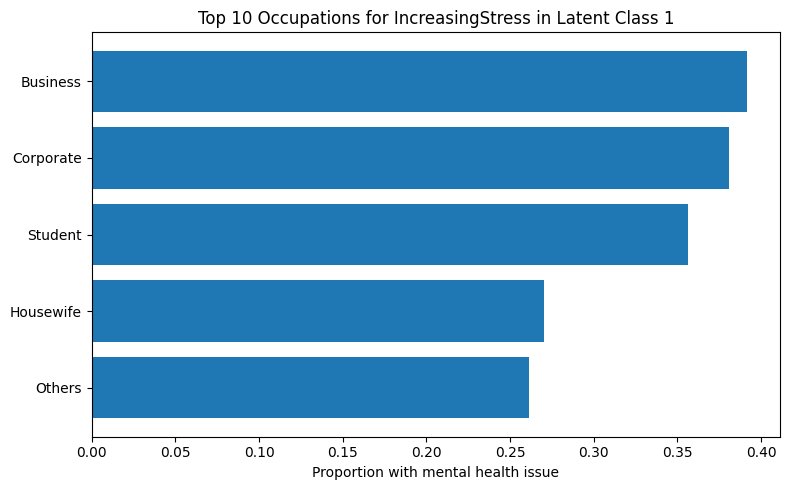

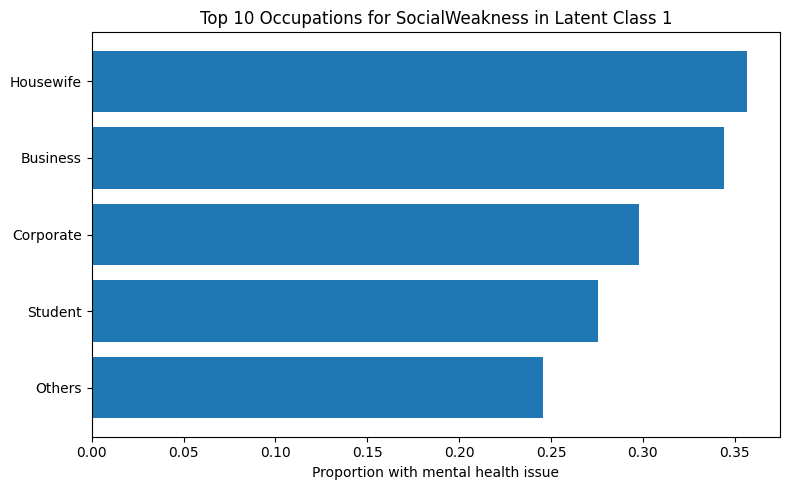

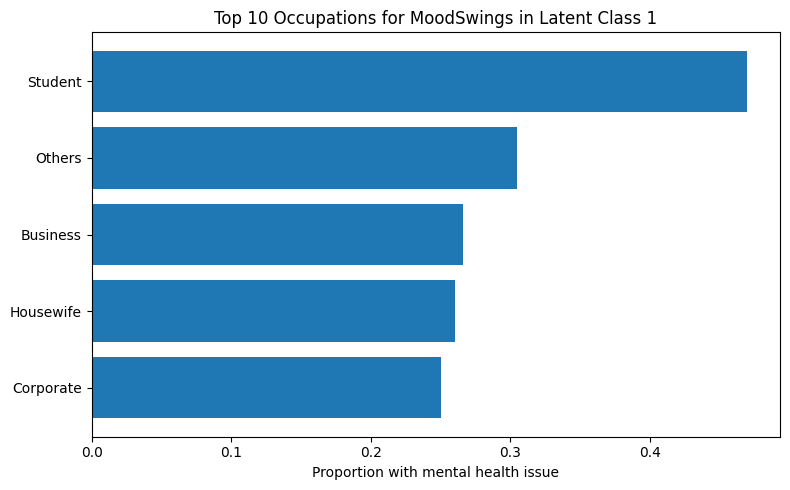

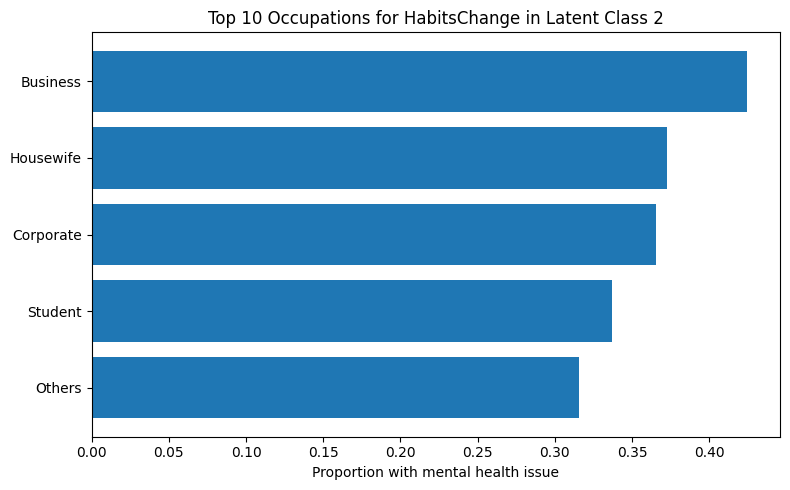

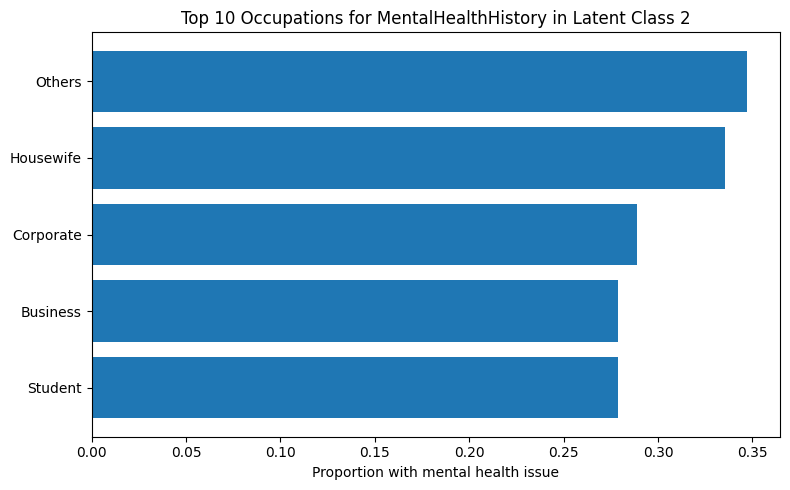

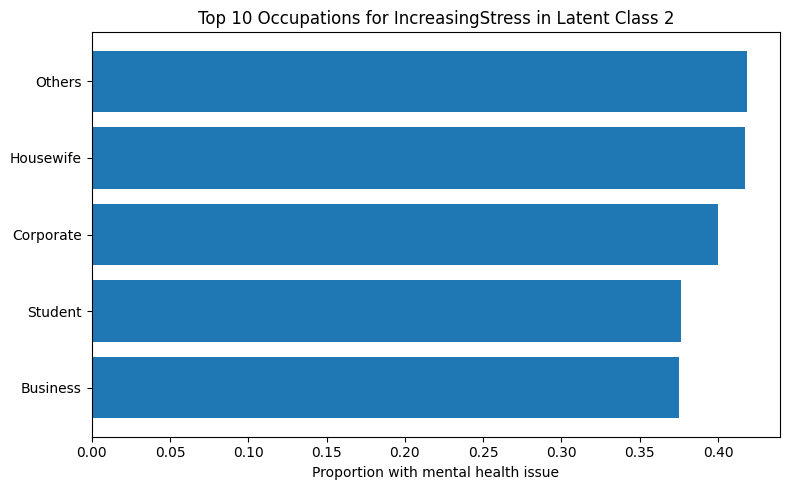

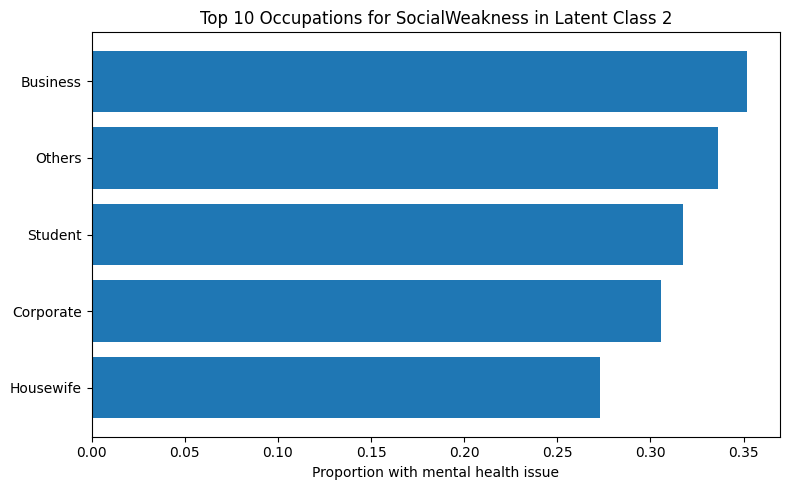

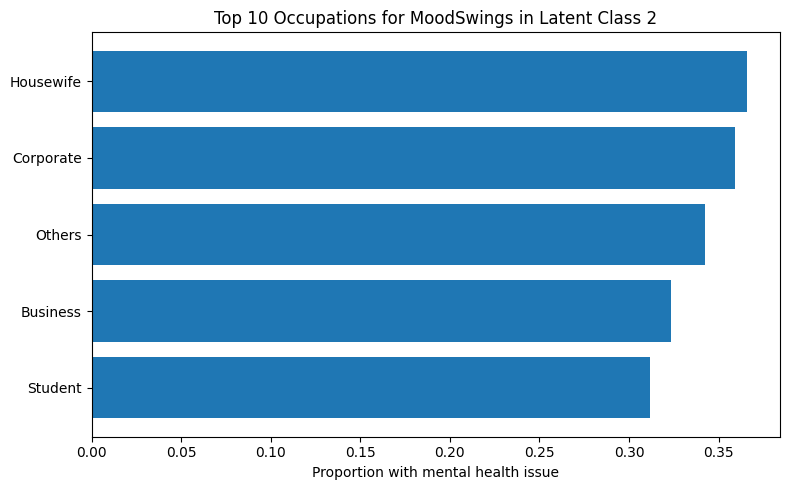

In [159]:
for c in sorted(df["LatentClass"].unique()):
    class_data = df[df["LatentClass"] == c]

    for o in outcomes:
        o_bin = o + "_bin"
       
        risk = (
            class_data.groupby("Occupation")[o_bin]
            .mean()
            .sort_values(ascending=False)
            .head(10)   # top 10 occupations
        )

      
        if risk.empty:
            continue

        plt.figure(figsize=(8, 5))
        plt.barh(risk.index, risk.values)
        plt.gca().invert_yaxis()  # highest at top
        plt.xlabel("Proportion with mental health issue")
        plt.title(f"Top 10 Occupations for {o} in Latent Class {c}")
        plt.tight_layout()
        plt.show()

In [160]:

class_sequence = [0, 1, 2]   # order classes 1 → 2 → 3

class_labels = {
    0: "Class 1 (31.0%)",
    1: "Class 2 (57.3%)",
    2: "Class 3 (11.7%)"
}


vars_to_plot = [
    "HabitsChange_bin",
    "IncreasingStress_bin",
    "SocialWeakness_bin",
    "MoodSwings_bin",
    "MentalHealthHistory_bin"
]


var_labels = [
    "Habits change",
    "Increasing stress",
    "Social weakness",
    "Mood swings",
    "Mental health history"
]
scale_factor = 5.0

In [161]:
class_counts = df["LatentClass"].value_counts(normalize=True).sort_index()

class_labels = [
    f"Class {i+1}, {p*100:.1f}%"
    for i, p in class_counts.items()
]


In [162]:
classes = sorted(df["LatentClass"].unique())
mean_matrix = []

for c in classes:
    sub = df[df["LatentClass"] == c]
    means = sub[vars_to_plot].mean() * scale_factor   
    mean_matrix.append(means.values)

mean_matrix = np.array(mean_matrix)

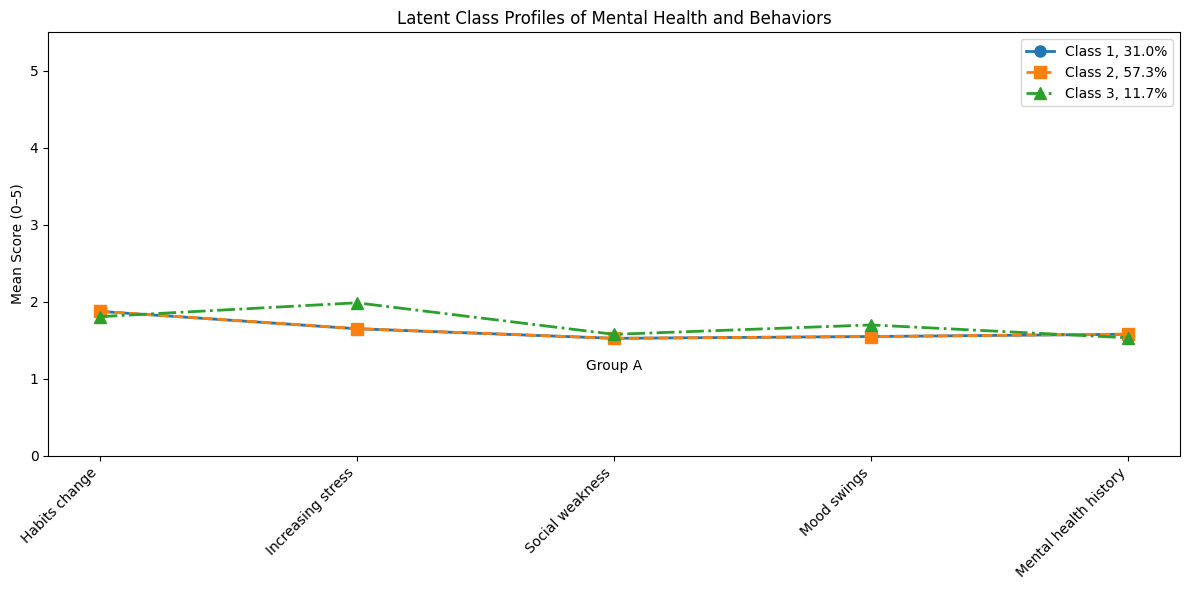

In [163]:
x = np.arange(len(var_labels))
markers = ["o", "s", "^"]
linestyles = ["-", "--", "-."]

plt.figure(figsize=(12, 6))


for i, c in enumerate(class_sequence):
    plt.plot(
        x,
        mean_matrix[i],
        marker=markers[i],
        linestyle=linestyles[i],
        label=class_labels[c],
        linewidth=2,
        markersize=8
    )

plt.xticks(x, var_labels, rotation=45, ha="right")
plt.ylabel("Mean Score (0–5)")
plt.title("Latent Class Profiles of Mental Health and Behaviors")


last_group = var_groups[0]
for idx in range(1, len(var_groups)):
    if var_groups[idx] != last_group:
        plt.axvline(x=idx - 0.5, color="gray", linestyle=":", linewidth=1)
        last_group = var_groups[idx]


group_positions = {}
for idx, g in enumerate(var_groups):
    group_positions.setdefault(g, []).append(idx)

y_min, y_max = plt.ylim()

for g, idxs in group_positions.items():
    mid = (min(idxs) + max(idxs)) / 2
    plt.text(mid, y_min - 0.25, g, ha="center", va="top", fontsize=10)

plt.ylim(0, 5.5)
plt.legend()
plt.tight_layout()
plt.show()

In [164]:
df["LatentClass"].value_counts(normalize=True)

LatentClass
1    0.573269
0    0.310104
2    0.116627
Name: proportion, dtype: float64